### Goald 1: Filtering Clustering Results - zoom in clusters
We went from 
- 233,961 sequences (with duplicates and matching entries) - hypothetical proteins, unknown proteins, uncharacterised, and in-house database (labelled hypothetical as well)
- 146,350 unique sequences 
- clustered down max to 125K previously

Now we have our finalised dataset after PHROGS, VFDB and CARDS filtering 
- 117,434 sequences

In [ ]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import numpy as np
import scipy.stats as stats

In [ ]:
# Turning csv into fasta file 
data = pd.read_csv('multifasta.tsv', sep='\t', usecols=['id', 'sequence'])
with open('multifasta.fasta', 'w') as fasta_file:
    for idx, row in data.iterrows():
        fasta_file.write(f">{row['id']}\n{row['sequence']}\n")

Best clustering method: connected component clustering with coverage mode 2, seq id 80%, cov 90%, cluster mode 1
Submitted files for clustering with mmseqs2 on HPC
- clustered from 117,434 to 100,317
- Removing all clusters that are in-house because already annotated to further reduce size bc still too big

In [ ]:
# Removing all clusters with in-house matches
data = pd.read_csv('results_coverage09_cov2_clust1_seqid08.tsv', sep='\t', header=None, names=['cluster_representative', 'in_cluster'])
data['cluster_representative'] = data['cluster_representative'].astype(str)
numeric_id_clusters = data[data['cluster_representative'].str.isnumeric()]['in_cluster'].unique()
filtered_data = data[~data['in_cluster'].isin(numeric_id_clusters)]
filtered_data.to_csv('wihtout_h_data.tsv', sep='\t', index=False)

In [2]:
data = pd.read_csv('wihtout_h_data.tsv', sep='\t')
data['cluster_representative'] = data['cluster_representative'].astype(str)
unique_clusters = data['cluster_representative'].nunique()
print(f"Number of unique clusters: {unique_clusters}")

Number of unique clusters: 95461


In [12]:
cluster_counts = data.groupby('cluster_representative')['in_cluster'].count()
average_ids_per_cluster = cluster_counts.mean()
print(f"Average number of IDs per cluster: {average_ids_per_cluster:.2f}")

Average number of IDs per cluster: 1.12


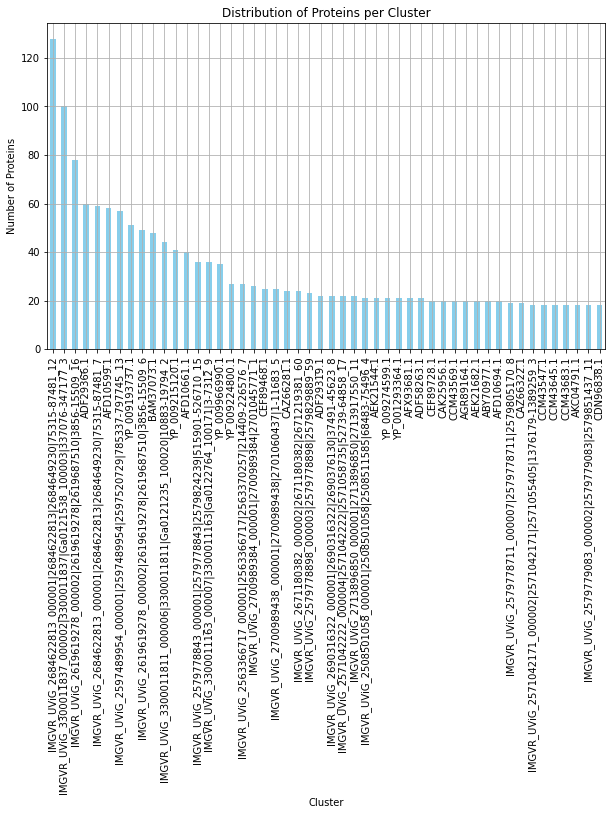

In [1]:
# Distribution of members per cluster
cluster_counts = data.groupby('cluster_representative')['in_cluster'].count()
top_clusters = cluster_counts.sort_values(ascending=False).head(50)
plt.figure(figsize=(10, 6))  
top_clusters.plot(kind='bar', color='skyblue')  
plt.title('Distribution of Proteins per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Proteins')
plt.grid(True)
plt.show()

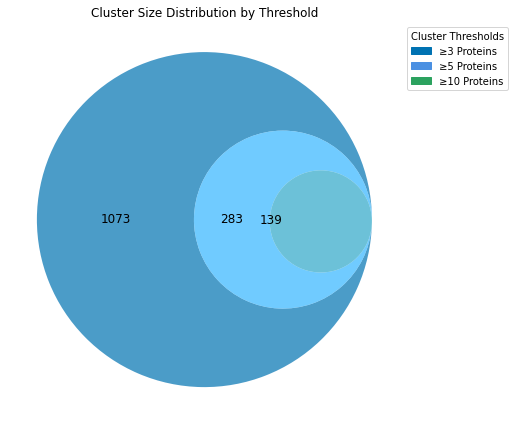

In [6]:
# Venn diagram of cluster size
cluster_sizes = data.groupby("cluster_representative").size()

# Thresholds
set_3 = set(cluster_sizes[cluster_sizes >= 3].index)
set_5 = set(cluster_sizes[cluster_sizes >= 5].index)
set_10 = set(cluster_sizes[cluster_sizes >= 10].index)

venn_colors = ['#0072b2','#4a90e2',  '#2ca25f'] 
plt.figure(figsize=(8, 6))
venn = venn3([set_3, set_5, set_10], set_labels=('', '', ''), set_colors=venn_colors, alpha=0.7)

for label in venn.set_labels:
    if label:
        label.set_text('')
for subset in venn.subset_labels:
    if subset:
        subset.set_fontsize(12)
        subset.set_horizontalalignment('center')
        subset.set_verticalalignment('center')

legend_labels = ['≥3 Proteins', '≥5 Proteins', '≥10 Proteins']
legend_handles = [Patch(color=color, label=label) for color, label in zip(venn_colors, legend_labels)]
plt.legend(handles=legend_handles, title='Cluster Thresholds', loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Cluster Size Distribution by Threshold")
plt.tight_layout()
plt.show()

In [7]:
# Check how many have at least 3 or more proteins per cluster - total of venn diagram
cluster_counts = data.groupby('cluster_representative')['in_cluster'].count()
clusters_with_at_least_3 = cluster_counts[cluster_counts >= 3]
print("Number of cluster representatives with at least 3 proteins:", len(clusters_with_at_least_3))

Number of cluster representatives with at least 3 proteins: 1495


In [8]:
# Saving 
cluster_counts = data.groupby('cluster_representative')['in_cluster'].count()
clusters_with_at_least_3 = cluster_counts[cluster_counts >= 3]
filtered_data = data[data['cluster_representative'].isin(clusters_with_at_least_3.index)]
filtered_data.to_csv('final_cluster_rep.tsv', sep='\t', index=False)

,cluster_representative,in_cluster
15,biochar_3855_5,biochar_3855_5
16,biochar_3855_5,biochar_72_75
17,biochar_3855_5,biochar_71_1
18,biochar_3855_5,biochar_71_90
180,biochar_5846_8,biochar_5846_8


8001 proteins within all clusters

then we need to: in folder fastas:
PROTEIN.fasta: fasta file for every hypothetical/unknown/uncharacterised proteins selected for structure prediction - so a cluster representative

- first take a the cluster reprenstatives and create a db with its sequence and sequence lenght, all in one tsv, then created PROTEIN.fasta in folder fastas from this tsv

In [9]:
cluster_rep_df = pd.read_csv('final_cluster_rep.tsv', sep='\t', header=None, usecols=[0], names=['cluster_representative'])
cluster_rep_df = cluster_rep_df['cluster_representative'].drop_duplicates()

fasta_df = pd.read_csv('multifasta.tsv', sep='\t', dtype={'id': str, 'sequence': str})
fasta_df['sequence'] = fasta_df['sequence'].astype(str)  #convert sequences to string

# Calculate protein length from sequence
fasta_df['length'] = fasta_df['sequence'].apply(len)
merged_df = fasta_df[fasta_df['id'].isin(cluster_rep_df)]
merged_df.to_csv('for_protein_fasta.tsv', sep='\t', index=False)

In [3]:
#  How many proteins/cluster
cluster_counts = cluster_rep_df['cluster_representative'].value_counts()

# Cluster with most proteins
most_proteins_cluster = cluster_counts.idxmax()
most_proteins_count = cluster_counts.max()
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ['cluster_representative', 'protein_count']

print("Top clusters by protein count:")
print(cluster_counts_df.head(10))

# Cluster with most proteins
print(f"\nCluster with the most proteins: {most_proteins_cluster}")
print(f"Number of proteins in that cluster: {most_proteins_count}")


Top clusters by protein count:
                              cluster_representative  protein_count
0  IMGVR_UViG_2684622813_000001|2684622813|268464...            128
1  IMGVR_UViG_3300011837_000002|3300011837|Ga0121...            100
2  IMGVR_UViG_2619619278_000002|2619619278|261968...             78
3                                         ADF29366.1             60
4  IMGVR_UViG_2684622813_000001|2684622813|268464...             59
5                                         AFD10599.1             58
6  IMGVR_UViG_2597489954_000001|2597489954|259752...             57
7                                     YP_009193737.1             51
8  IMGVR_UViG_2619619278_000002|2619619278|261968...             49
9                                         BAM37073.1             48

Cluster with the most proteins: IMGVR_UViG_2684622813_000001|2684622813|2684649230|75315-87481_12
Number of proteins in that cluster: 128


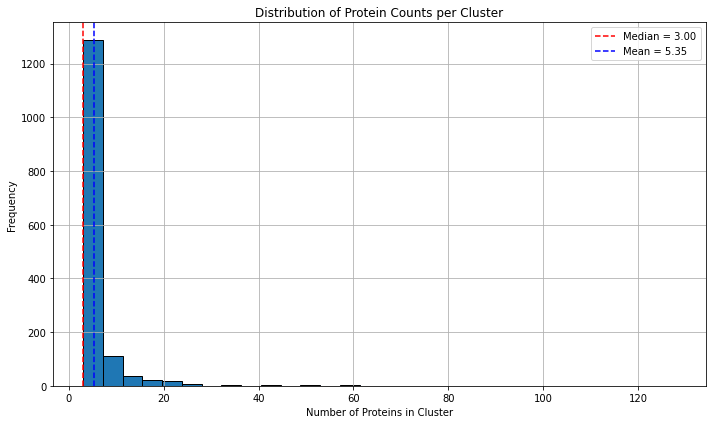

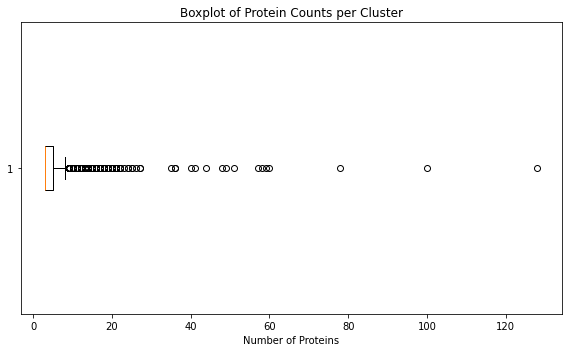

(np.float64(3.0),
 np.float64(5.351839464882943),
 np.float64(6.9564014436461115),
 (np.float64(5.05590789569205), np.float64(5.647771034073836)))

In [6]:
median = cluster_counts.median()
mean = cluster_counts.mean()
std_dev = cluster_counts.std()

# 90% CI for mean using normal approximation
confidence_level = 0.90
z_score = stats.norm.ppf((1 + confidence_level) / 2)
margin_of_error = z_score * (std_dev / np.sqrt(len(cluster_counts)))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

# Histogram 
plt.figure(figsize=(10, 6))
plt.hist(cluster_counts, bins=30, edgecolor='black')
plt.axvline(median, color='red', linestyle='dashed', linewidth=1.5, label=f'Median = {median:.2f}')
plt.axvline(mean, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean = {mean:.2f}')
plt.title('Distribution of Protein Counts per Cluster')
plt.xlabel('Number of Proteins in Cluster')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(cluster_counts, vert=False)
plt.title('Boxplot of Protein Counts per Cluster')
plt.xlabel('Number of Proteins')
plt.tight_layout()
plt.show()

(median, mean, std_dev, confidence_interval)
